# Project: Credit Scoring for ACB Bank
## A. Introduction
### Credit: [SkillCate](https://medium.com/@skillcate/credit-scoring-project-using-logistic-regression-c1e88bd7cf25)
### Business Case
Our client is ABC Bank ltd. They intend to build an in-house risk model to make data-driven lending decisions for subprime mortgages.
Business wants to maximise profit, with an eye on market expansion.
- **Bad Loan**: Incur $500 in loss
- **Good Loan**: Incure $100 in profit

### 2. Variables
- **Target,** is a binary varible (0 for Good Loan, 1 for Bad Loan)
- **Bankruptcy Indicator**, is a number indicating borrower’s likelihood of filing for bankruptcy
- **Public Derogatories**, is the count of late payments or defaults
- **Financial Enquiries**, is the count of credit enquiries made in last few months
- **Trade line**, is a number indicating the number of credit accounts a borrower has, be it: loan, credit card, or other debt obligations. So, basically if you have a credit card and a home loan at a certain point in time, you have 2 trade lines open
- **Customer ID**, is a unique identifier for every applicant in database

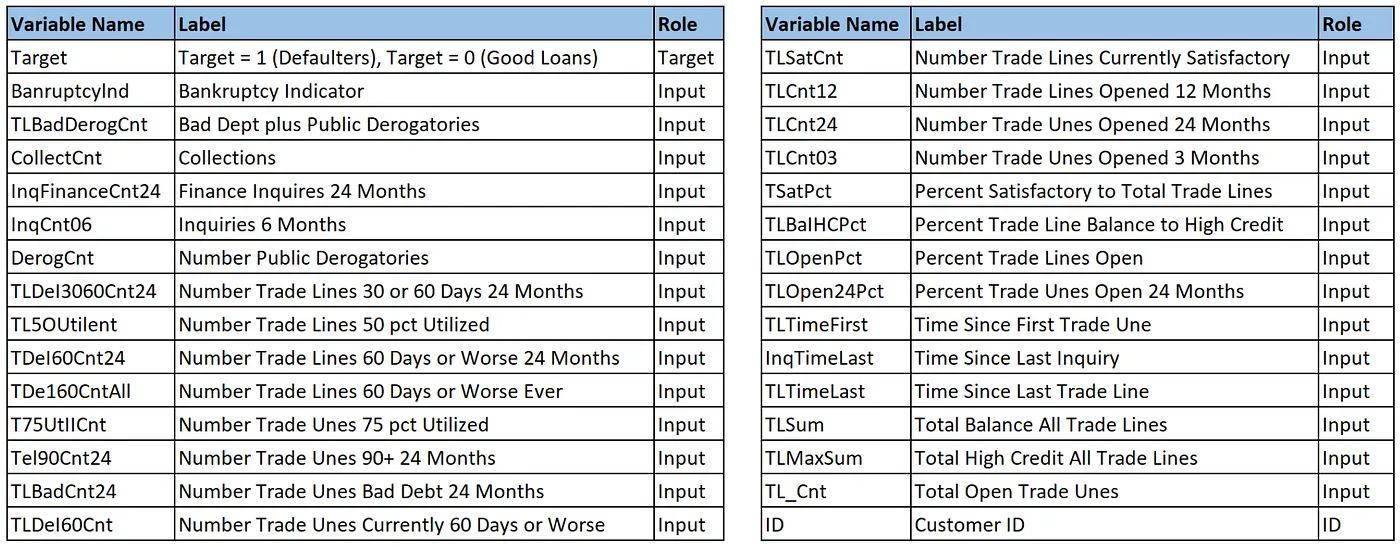

## B. Analysis

## 1. Import Libraries & Data

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression


from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.metrics import (confusion_matrix, classification_report, ConfusionMatrixDisplay,
                             auc, roc_curve, roc_auc_score, RocCurveDisplay,
                             precision_recall_curve, PrecisionRecallDisplay,
                             precision_score, recall_score, f1_score,
                             accuracy_score
                             )
from sklearn.model_selection import GridSearchCV, cross_val_score

from scipy import stats
import statsmodels.api
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.special import expit

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (5, 5)

In [87]:
df = pd.read_csv('Data/a_Dataset_CreditScoring.csv')
df.head()

,TARGET,ID,DerogCnt,CollectCnt,BanruptcyInd,InqCnt06,InqTimeLast,InqFinanceCnt24,TLTimeFirst,TLTimeLast,...,TL50UtilCnt,TLBalHCPct,TLSatPct,TLDel3060Cnt24,TLDel90Cnt24,TLDel60CntAll,TLOpenPct,TLBadDerogCnt,TLDel60Cnt24,TLOpen24Pct
0,1,582,3,3,0,4,0.0,5,117,27,...,3.0,92%,21%,2,3,7,21%,4,4,0%
1,1,662,15,9,0,3,1.0,3,14,14,...,1.0,80%,0%,0,0,0,100%,12,0,100%
2,1,805,0,0,0,1,5.0,1,354,7,...,5.0,36%,65%,0,1,1,73%,1,1,53%
3,1,1175,8,5,0,6,1.0,10,16,4,...,3.0,91%,25%,1,1,1,75%,7,1,133%
4,1,1373,3,1,0,9,0.0,8,130,52,...,1.0,125%,0%,0,1,4,14%,3,1,0%


In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TARGET           3000 non-null   int64  
 1   ID               3000 non-null   int64  
 2   DerogCnt         3000 non-null   int64  
 3   CollectCnt       3000 non-null   int64  
 4   BanruptcyInd     3000 non-null   int64  
 5   InqCnt06         3000 non-null   int64  
 6   InqTimeLast      2812 non-null   float64
 7   InqFinanceCnt24  3000 non-null   int64  
 8   TLTimeFirst      3000 non-null   int64  
 9   TLTimeLast       3000 non-null   int64  
 10  TLCnt03          3000 non-null   int64  
 11  TLCnt12          3000 non-null   int64  
 12  TLCnt24          3000 non-null   int64  
 13  TLCnt            2997 non-null   float64
 14  TLSum            2960 non-null   object 
 15  TLMaxSum         2960 non-null   object 
 16  TLSatCnt         2996 non-null   float64
 17  TLDel60Cnt    

## 2. Exploratory Data Analysis

### 2.1. Clean Data

In [89]:
categorical_col ="BanruptcyInd"
time_columns = ['InqTimeLast', 'TLTimeFirst', 'TLTimeLast']
currency_columns = ['TLSum','TLMaxSum']
percent_columns = ['TLBalHCPct', 'TLSatPct', 'TLOpenPct','TLOpen24Pct']
count_columns = [col for col in df.columns if 'Cnt' in col]
quantitative_columns = percent_columns + currency_columns + count_columns + time_columns

# Drop unncessary data
df_backup = df.copy()
if 'ID' in df.columns:
    df.drop(columns = ['ID'], inplace=True)
print("Dropped Column: ", ['ID'])

print()
# Data Format

for col in currency_columns:
    if df.dtypes[col] == 'object':
        df[col] = df[col].str.replace(",","" ).str.replace("$","").astype(np.float64)

for col in percent_columns:
    if df.dtypes[col] == 'object':
        df[col] = df[col].str.replace("%","").astype(np.float64)
print("Converted to Float: ", currency_columns + percent_columns)
print()

for col in count_columns:
    if df.dtypes[col] != 'Int64':
        df[col] = df[col].astype('Int64')
print("Converted to Int: ", count_columns)
print()

# Check Data Validity
if df['BanruptcyInd'].min() < 0 or df['BanruptcyInd'].max() > 1:
    print(f"Contains values out of bound: {col}, min={df[col].min() }, max={df[col].max()}")

Dropped Column:  ['ID']

Converted to Float:  ['TLSum', 'TLMaxSum', 'TLBalHCPct', 'TLSatPct', 'TLOpenPct', 'TLOpen24Pct']

Converted to Int:  ['DerogCnt', 'CollectCnt', 'InqCnt06', 'InqFinanceCnt24', 'TLCnt03', 'TLCnt12', 'TLCnt24', 'TLCnt', 'TLSatCnt', 'TLDel60Cnt', 'TLBadCnt24', 'TL75UtilCnt', 'TL50UtilCnt', 'TLDel3060Cnt24', 'TLDel90Cnt24', 'TLDel60CntAll', 'TLBadDerogCnt', 'TLDel60Cnt24']



In [90]:
# Check Duplicate Values
print("Count of Duplicate Rows: ", df.duplicated().sum())
# Check Missing Values
null_counts = df.isna().sum()
print("Count of Missing Values by Column:")
display(null_counts[null_counts > 0].sort_values())
print(f"Count of Rows containing Missing Values: {df.shape[0] - df.dropna().shape[0]}")

target_col = "TARGET"
X = df.drop(columns=[target_col])
y = df[target_col]

Count of Duplicate Rows:  0
Count of Missing Values by Column:


TLCnt            3
TLOpenPct        3
TLOpen24Pct      3
TLSatCnt         4
TLSatPct         4
TLSum           40
TLMaxSum        40
TLBalHCPct      41
TL75UtilCnt     99
TL50UtilCnt     99
InqTimeLast    188
dtype: int64

Count of Rows containing Missing Values: 272


### 2.2. Profile Categorical Data

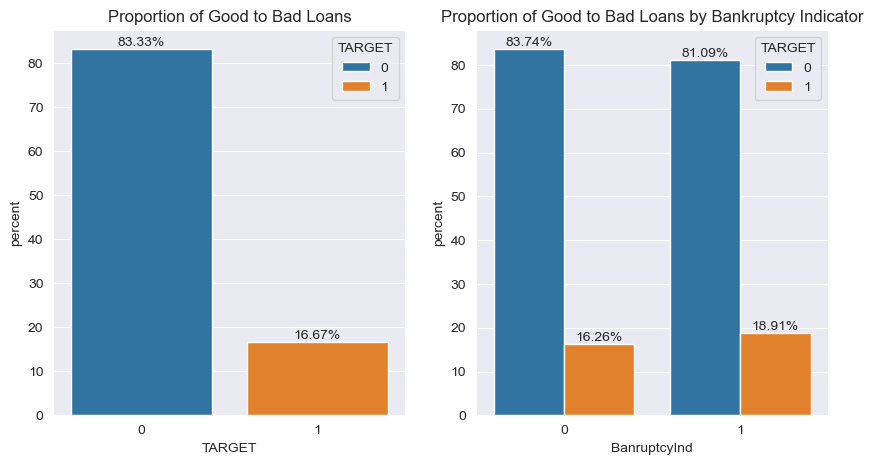

In [91]:


fig, ax = plt.subplots(ncols=2)
fig.set_figheight(5)
fig.set_figwidth(10)


sns.countplot(df, x=target_col, hue=target_col, stat='percent', ax = ax[0])
ax[0].set_title("Proportion of Good to Bad Loans")
for bar in ax[0].containers:
    ax[0].bar_label(bar, fmt = lambda v: f"{v:.2f}%")

df_target_by_bank_ind = df.groupby([categorical_col, target_col]).size().reset_index(name='count')
df_target_by_bank_ind['total'] = df_target_by_bank_ind.groupby(categorical_col)['count'].transform('sum')
df_target_by_bank_ind["percent"] = df_target_by_bank_ind['count'] * 100.0 / df_target_by_bank_ind['total']
sns.barplot(df_target_by_bank_ind, x=categorical_col, y = "percent", hue=target_col, ax = ax[1])
ax[1].set_title("Proportion of Good to Bad Loans by Bankruptcy Indicator")

for bar in ax[1].containers:
    ax[1].bar_label(bar, fmt = lambda v: f"{v:.2f}%")
    
plt.show()

In [92]:
thresh = 5
print("Chi-Square Test of Association:")
if df_target_by_bank_ind[df_target_by_bank_ind['count'] <=  thresh].shape[0]:
    print(f"Can NOT apply. Has count <= {thresh}")
else:
    print("Can apply. All counts > {thresh}")
    res = stats.chi2_contingency(pd.crosstab( df[target_col], df[categorical_col]) )
    alpha = 0.1
    print(f"p-Value: {res.pvalue}")
    if res.pvalue < alpha:
        print(f"Reject H0: {target_col} and {categorical_col} are not indepdent")
    else:
        print(f"Fail to Reject H0: {target_col} and {categorical_col} are indepdent")


Chi-Square Test of Association:
Can apply. All counts > {thresh}
p-Value: 0.18122217918524391
Fail to Reject H0: TARGET and BanruptcyInd are indepdent


### 2.3. Profile Quantitative Data

In general, 

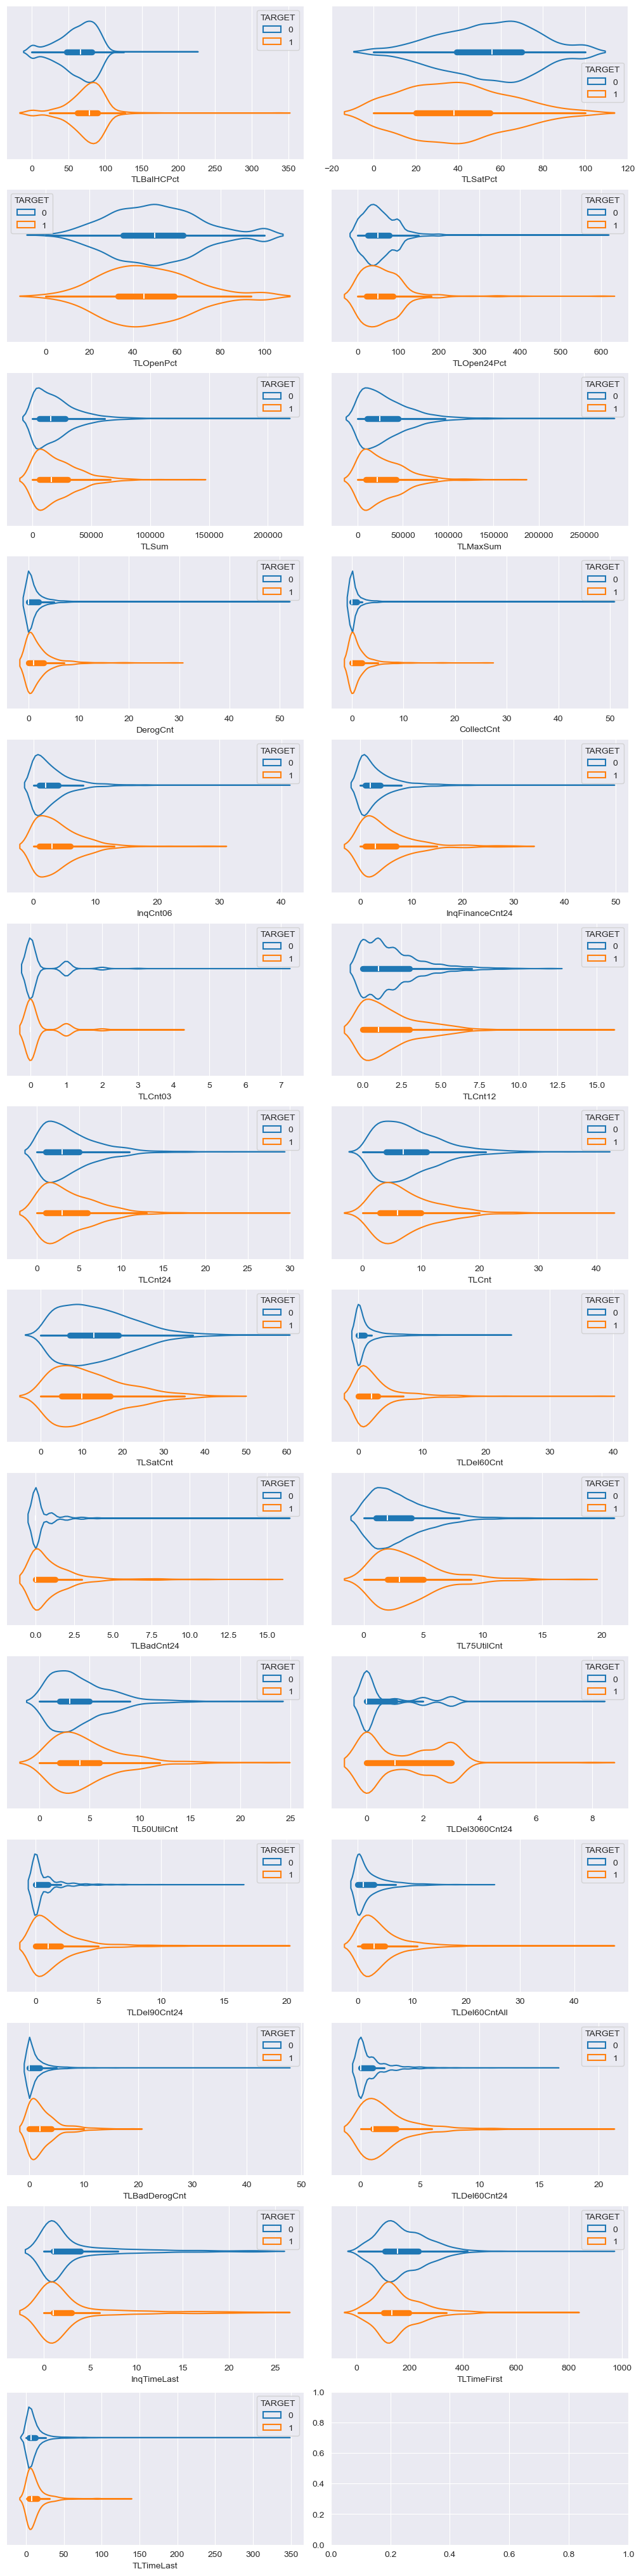

In [93]:
fig, ax = plt.subplots(nrows=round(len(quantitative_columns)/2), ncols=2, constrained_layout=True)
ax = ax.ravel()
fig.set_figwidth(10)
fig.set_figheight(len(quantitative_columns)*1.5)

for i in range(len(quantitative_columns)):
    sns.violinplot( df, x = quantitative_columns[i], ax = ax[i], 
                   hue=target_col, fill=False, split=False)
plt.show()

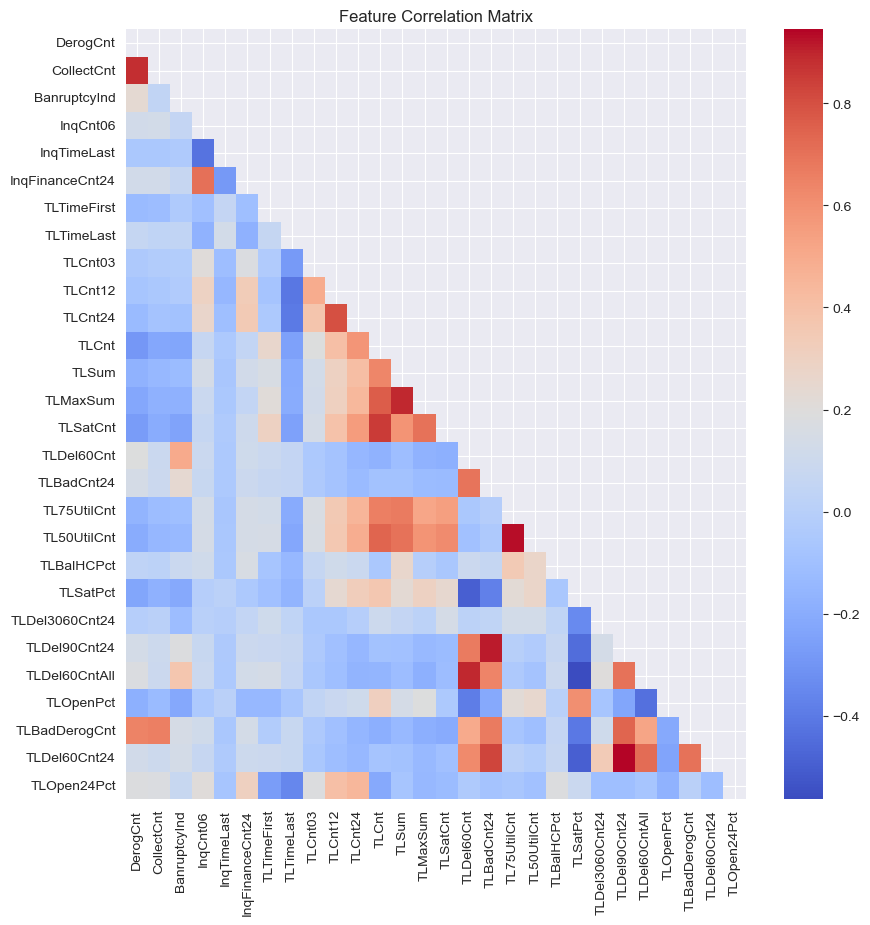

In [94]:
corr_matrix = df[X.columns].corr()
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
sns.heatmap(corr_matrix, mask= np.triu(corr_matrix), cmap='coolwarm', ax = ax)

ax.set_title("Feature Correlation Matrix")
plt.show()

Pearson Correlation Coefficient > 0.8:
['DerogCnt', 'CollectCnt']
['TLCnt', 'TLSatCnt']
['TLSum', 'TLMaxSum']
['TLDel60Cnt', 'TLDel60CntAll']
['TLBadCnt24', 'TLDel90Cnt24']
['TLBadCnt24', 'TLDel60Cnt24']
['TL75UtilCnt', 'TL50UtilCnt']
['TLDel90Cnt24', 'TLDel60Cnt24']


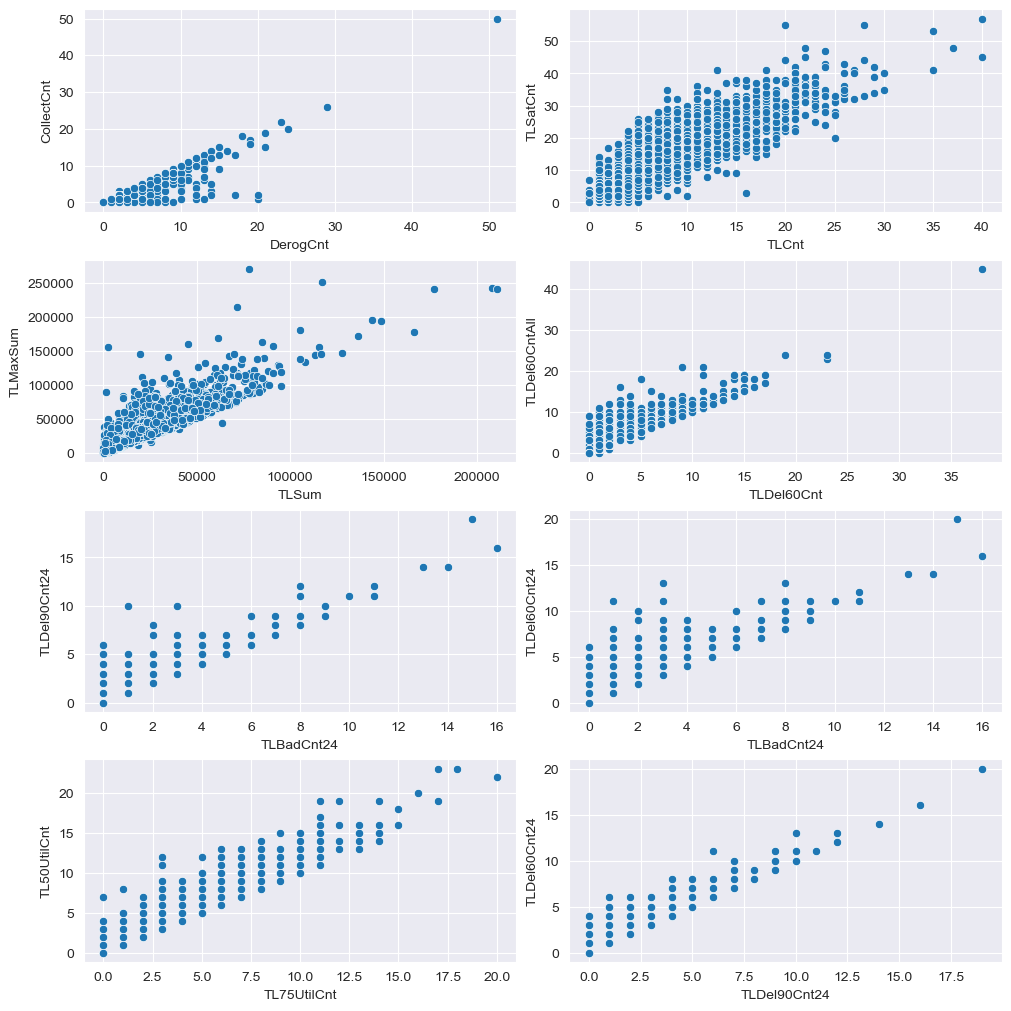

In [95]:
high_corr = []
print("Pearson Correlation Coefficient > 0.8:")
for i, row in corr_matrix.map(lambda x: abs(x) > 0.8 and abs(x) < 1).iterrows():
    for col in corr_matrix.columns.to_list():
        if row[col] and [col, i] not in high_corr:
            high_corr.append([i, col])
            print([i, col])

fig, ax = plt.subplots(nrows=round(len(high_corr)/2), ncols=2, constrained_layout = True)
ax = ax.ravel()
fig.set_figheight(10)
fig.set_figwidth(10)
for i in  range(len(high_corr)):
    sns.scatterplot(df, x = high_corr[i][0], y = high_corr[i][1], ax = ax[i])
plt.show()

### 2.4. Split Training & Test Data

In [96]:
excluded_columns = ["BanruptcyInd"]
# ["CollectCnt", "TLCnt", "TLDel60CntAll", "TL75UtilCnt", "TLBadCnt24"]

included_columns = [i for i in percent_columns + currency_columns + count_columns + time_columns + [categorical_col] 
                if i not in excluded_columns]

X_reduced = X[included_columns]

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y,
                                                   test_size=0.15, random_state=207, stratify=y)

print(f"Size of Train Set: {X_train.shape}")
print(f"Size of Test Set: {X_test.shape}")

print(f"Percentage of Positive Case (Yes) in Train Set: {y_train.mean()*100:.2f}%")
print(f"Percentage of Positive Case (Yes) in Test Set: {y_test.mean()*100:.2f}%")


Size of Train Set: (2550, 27)
Size of Test Set: (450, 27)
Percentage of Positive Case (Yes) in Train Set: 16.67%
Percentage of Positive Case (Yes) in Test Set: 16.67%


### 2.5. Evaluate Feature Importance

Top 15 most important features:
            Feature  Importance
1          TLSatPct    0.071811
0        TLBalHCPct    0.069420
25      TLTimeFirst    0.066467
4             TLSum    0.059592
5          TLMaxSum    0.054501
14         TLSatCnt    0.043784
2         TLOpenPct    0.043575
23     TLDel60Cnt24    0.043001
3       TLOpen24Pct    0.042716
9   InqFinanceCnt24    0.041014
26       TLTimeLast    0.039969
17      TL75UtilCnt    0.034380
8          InqCnt06    0.033925
18      TL50UtilCnt    0.033902
19   TLDel3060Cnt24    0.033676


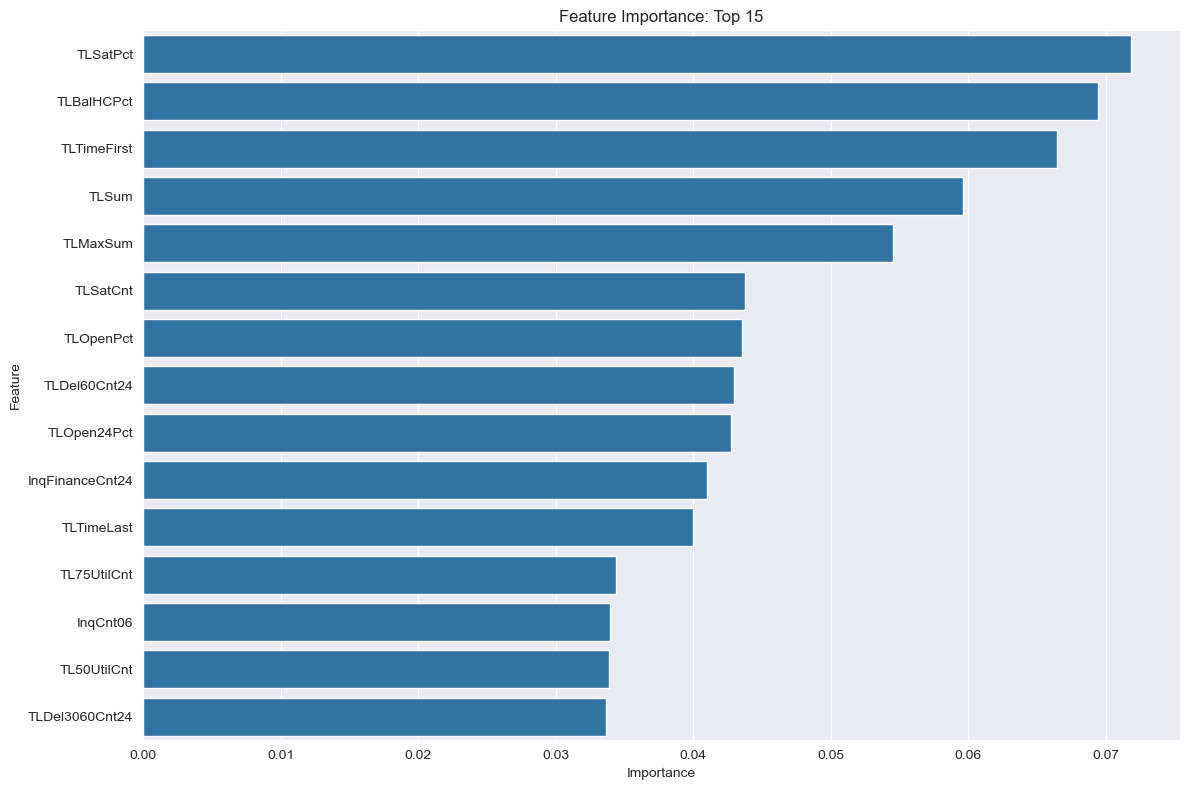

In [97]:
# Train a Random Forest for feature importance
rf_model = RandomForestClassifier(n_estimators=100, criterion="gini", random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importance
feature_importances = pd.DataFrame({
    'Feature': X_reduced.columns.to_list(),
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 15 most important features:")
print(feature_importances[:15])

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances[:15])
plt.title('Feature Importance: Top 15')
plt.tight_layout()
plt.show()


## 3. Model Building
### 3.1. Logistic Regression

In [98]:
def calculate_metrics(obs, pred, preds_proba):
    accuracy = accuracy_score(obs, pred)
    precision = precision_score(obs, pred)
    recall = recall_score(obs, pred)
    f1 = f1_score(obs, pred)
    auc_roc = roc_auc_score(obs, preds_proba)
    return accuracy, precision, recall, f1, auc_roc


def plot_performance_metrics(model, y_val, y_val_pred, y_val_pred_proba):
    fig, ax = plt.subplots(ncols=3)
    fig.tight_layout()
    fig.set_figheight(5)
    fig.set_figwidth(15)
    # Confusion Matrix
    cm = confusion_matrix(y_val, y_val_pred)
    cm_display = ConfusionMatrixDisplay(cm)
    cm_display.plot(ax=ax[0], colorbar = False)
    ax[0].set_title('Confusion Matrix')
    ax[0].grid(False)
    # ROC
    fpr, tpr, _ = roc_curve(y_val, y_val_pred_proba)
    roc_auc = auc(fpr, tpr)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    roc_display.plot(ax=ax[1])
    ax[1].set_title('ROC')


    # Precision Recall
    prec, recall, _ = precision_recall_curve(y_val, y_val_pred_proba, 
                                            pos_label= model.classes_[1])
    pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)
    pr_display.plot(ax=ax[2])
    ax[2].set_title('Precision-Recall')


In [99]:

preprocessor_scaler = ColumnTransformer(    [
        ("scaler_min_max", MinMaxScaler( feature_range=(0,100)), [included_columns.index(i) for i in percent_columns if i in included_columns ] ),
        ("scaler_standard", StandardScaler(), [included_columns.index(i) for i in  currency_columns + count_columns + time_columns if i in included_columns] )
    ],
    remainder="passthrough"
)
model_log_reg = LogisticRegression(max_iter=10000, 
                                      random_state=207, 
                                      class_weight='balanced')
pipeline_log_reg = Pipeline( steps= 
                            [
                                ("imputer_nan", SimpleImputer(strategy="median")),
                                ("preprocessor_scaler", preprocessor_scaler),
                                ("classifier", model_log_reg)
                            ]
)

pipeline_log_reg.fit(X_train, y_train)

Pipeline(steps=[('imputer_nan', SimpleImputer(strategy='median')),
                ('preprocessor_scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler_min_max',
                                                  MinMaxScaler(feature_range=(0,
                                                                              100)),
                                                  [0, 1, 2, 3]),
                                                 ('scaler_standard',
                                                  StandardScaler(),
                                                  [4, 5, 6, 7, 8, 9, 10, 11, 12,
                                                   13, 14, 15, 16, 17, 18, 19,
                                                   20, 21, 22, 23, 24, 25,
                                                   26])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=10000,
                                    random_state=207))])

### 3.2. Hyperparameter Tuning with Grid Search

In [100]:
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']
}
grid_search = GridSearchCV(
    pipeline_log_reg, 
    param_grid=param_grid, 
    cv=5, 
    scoring='f1'
)
# Fit grid search
print("Starting grid search...")
grid_search.fit(X_train, y_train)
print("Grid search completed!")

Starting grid search...
Grid search completed!


In [ ]:
# Analyzing Grid Search Results

# Get best parameters and score
print("Optimized for F1")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Analyze all results
cv_results = pd.DataFrame(grid_search.cv_results_)

# Display mean test scores for each parameter combination
print("\nTop 5 parameter combinations by performance:")
cv_results[['param_classifier__C', 'param_classifier__penalty', 
            'param_classifier__solver', 'mean_test_score','std_test_score','mean_fit_time','std_fit_time']]\
    .sort_values('mean_test_score', ascending=False).head()

Optimized for Precision
Best parameters: {'classifier__C': 10, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best cross-validation score: 0.4621

Top 5 parameter combinations by performance:


,param_classifier__C,param_classifier__penalty,param_classifier__solver,mean_test_score,std_test_score,mean_fit_time,std_fit_time
16,10.0,l1,liblinear,0.462121,0.045983,0.051896,0.009607
15,1.0,l2,saga,0.461417,0.045886,0.592976,0.077115
18,10.0,l2,liblinear,0.461392,0.045812,0.028079,0.005603
17,10.0,l1,saga,0.461077,0.046100,0.751663,0.103086
21,100.0,l1,saga,0.460688,0.045712,0.770463,0.102613


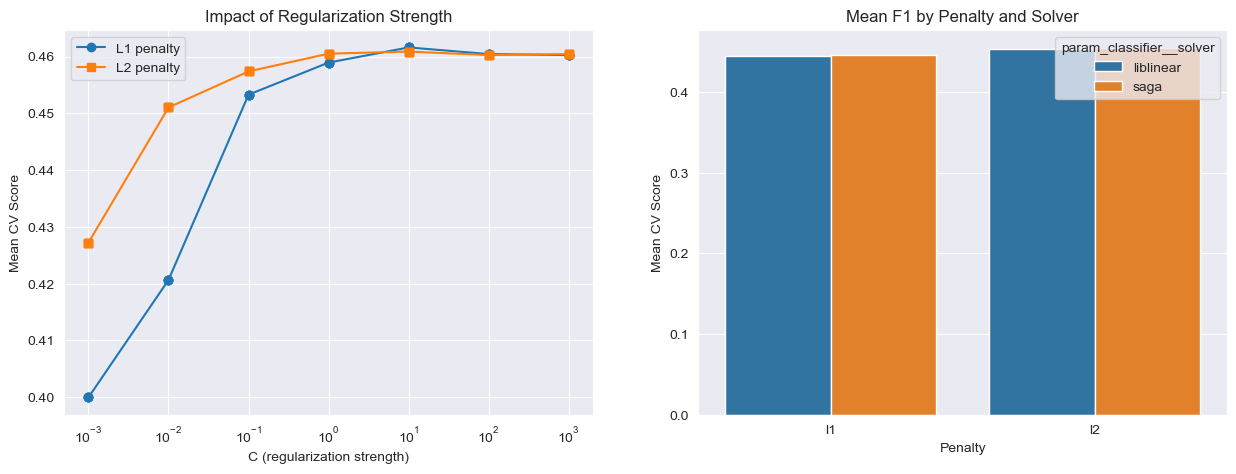

In [102]:
# Create visualization of parameter impact
fig, (ax1, ax2) =plt.subplots(ncols=2, figsize=(15, 10))
fig.set_figheight(5)

# Plot for C parameter (regularization strength)
C_values = cv_results['param_classifier__C']
l1_scores = cv_results[cv_results['param_classifier__penalty'] == 'l1'].groupby('param_classifier__C')['mean_test_score'].mean()
l2_scores = cv_results[cv_results['param_classifier__penalty'] == 'l2'].groupby('param_classifier__C')['mean_test_score'].mean()

ax1.semilogx(C_values, [l1_scores.get(c, 0) for c in C_values], 'o-', label='L1 penalty')
ax1.semilogx(C_values, [l2_scores.get(c, 0) for c in C_values], 's-', label='L2 penalty')
ax1.xaxis.set_label_text('C (regularization strength)')
ax1.yaxis.set_label_text('Mean CV Score')
ax1.set_title('Impact of Regularization Strength')
ax1.legend()

# Plot for penalty and solver combinations
pen_solver = cv_results.groupby(['param_classifier__penalty', 'param_classifier__solver'])['mean_test_score'].mean()
pen_solver = pen_solver.reset_index()
ax2 = sns.barplot(x='param_classifier__penalty', y='mean_test_score', 
           hue='param_classifier__solver', data=pen_solver)
ax2.set_title('Mean F1 by Penalty and Solver')
ax2.xaxis.set_label_text('Penalty')
ax2.yaxis.set_label_text('Mean CV Score')

plt.show()

Performance Metrics on Training Set:
Accuracy: 0.7337
Precision: 0.3516
Recall: 0.7082
F1 Score: 0.4699
AUC-ROC: 0.7957
Classification Report, Threshold  0.5
              precision    recall  f1-score   support

 Not Churned       0.93      0.74      0.82      2125
     Churned       0.35      0.71      0.47       425

    accuracy                           0.73      2550
   macro avg       0.64      0.72      0.65      2550
weighted avg       0.83      0.73      0.76      2550



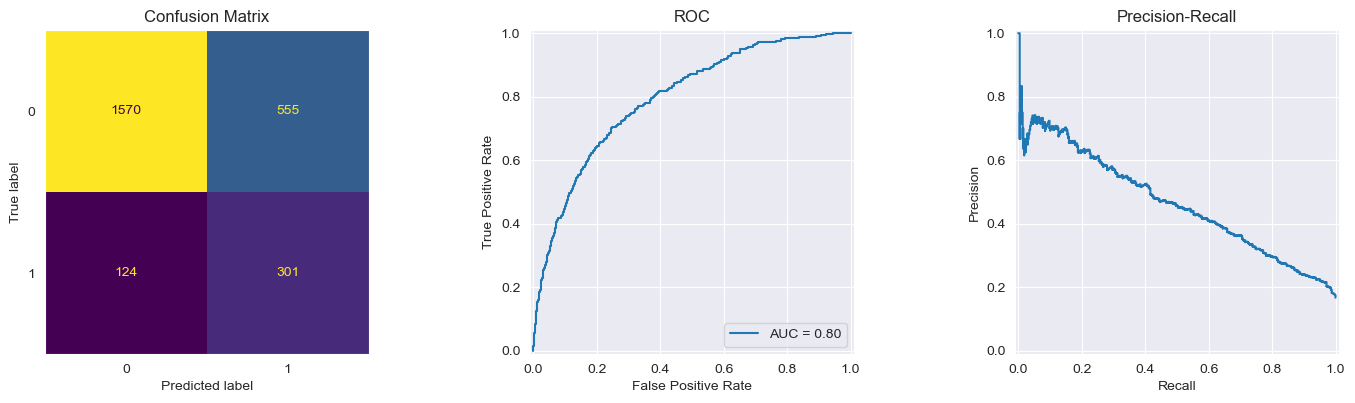

In [ ]:
model_log_reg_optimized = LogisticRegression(
    class_weight='balanced',
    C=grid_search.best_params_['classifier__C'],
    penalty=grid_search.best_params_['classifier__penalty'],
    solver=grid_search.best_params_['classifier__solver'],
    random_state=207
)

pipeline_log_reg_optimized = Pipeline( steps=[
                                ("imputer_nan", SimpleImputer(strategy="median")),
                                ("preprocessor_scaler", preprocessor_scaler),
                                ("classifier", model_log_reg_optimized)    
]
)

pipeline_log_reg_optimized.fit(X_train, y_train)

y_train_pred = pipeline_log_reg_optimized.predict(X_train)
y_train_pred_proba = pipeline_log_reg_optimized.predict_proba(X_train)[:, 1]

accuracy_optimized, precision_optimized, recall_optimized, f1_optimized, auc_roc_optimized = \
    calculate_metrics(
        y_train, y_train_pred, y_train_pred_proba
    )

print("Performance Metrics on Training Set:")
print(f"Accuracy: {accuracy_optimized:.4f}")
print(f"Precision: {precision_optimized:.4f}")
print(f"Recall: {recall_optimized:.4f}")
print(f"F1 Score: {f1_optimized:.4f}")
print(f"AUC-ROC: {auc_roc_optimized:.4f}")

# 6. Plot Confusion Matrix, ROC and Precision Recall
print(f"Classification Report, Threshold  {0.5}")
print(classification_report(y_train, y_train_pred, 
                            target_names=['Not Churned', 'Churned']))
plot_performance_metrics(pipeline_log_reg, y_train, y_train_pred, y_train_pred_proba)

### 3.3. Evaluate on Test Set

Performance Metrics on Test Set:
Accuracy: 0.7444
Precision: 0.3667
Recall: 0.7333
F1 Score: 0.4889
AUC-ROC: 0.8132
Classification Report, Threshold  0.5
              precision    recall  f1-score   support

 Not Churned       0.93      0.75      0.83       375
     Churned       0.37      0.73      0.49        75

    accuracy                           0.74       450
   macro avg       0.65      0.74      0.66       450
weighted avg       0.84      0.74      0.77       450



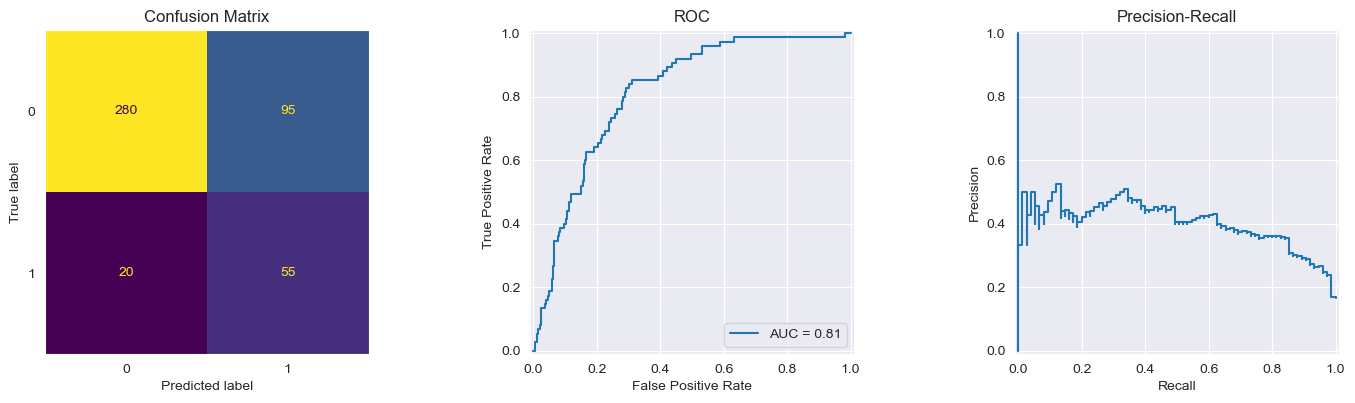

In [134]:

y_test_pred = pipeline_log_reg_optimized.predict(X_test)
y_test_pred_proba = pipeline_log_reg_optimized.predict_proba(X_test)[:, 1]

accuracy_optimized, precision_optimized, recall_optimized, f1_optimized, auc_roc_optimized = \
    calculate_metrics(
        y_test, y_test_pred, y_test_pred_proba
    )

print("Performance Metrics on Test Set:")
print(f"Accuracy: {accuracy_optimized:.4f}")
print(f"Precision: {precision_optimized:.4f}")
print(f"Recall: {recall_optimized:.4f}")
print(f"F1 Score: {f1_optimized:.4f}")
print(f"AUC-ROC: {auc_roc_optimized:.4f}")

# 6. Plot Confusion Matrix, ROC and Precision Recall
print(f"Classification Report, Threshold  {0.5}")
print(classification_report(y_test, y_test_pred, 
                            target_names=['Not Churned', 'Churned']))
plot_performance_metrics(pipeline_log_reg, y_test, y_test_pred, y_test_pred_proba)

Profit from Good Loan($): 100.0
Loss from Bad Loan($): -500.0
Based on Test Set,
Threshold to Maximize Profit: 44.36%


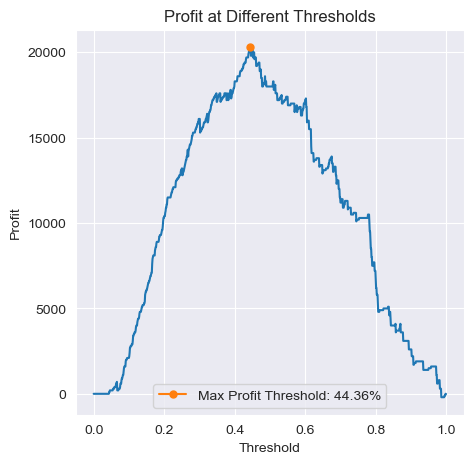

In [160]:
from scipy.optimize import minimize_scalar

profit_good_loan = 100.0
loss_bad_loan = -500.0

def objective_function(thresh, y_pred_proba, y_actual):
    y_pred_thresh = y_pred_proba > thresh
    approved_loans = y_actual[~y_pred_thresh]
    bad_loan = len(approved_loans[approved_loans ==1])
    profit = loss_bad_loan * bad_loan + profit_good_loan * (len(approved_loans) - bad_loan)
    return -profit

result = minimize_scalar(lambda x: objective_function(x, y_test_pred_proba, y_test), bounds=[0.1, 0.9] , method='Bounded')
print(f"Profit from Good Loan($): {profit_good_loan}")
print(f"Loss from Bad Loan($): {loss_bad_loan}")
print("Based on Test Set,")
print(f"Threshold to Maximize Profit: {round(result.x * 100.0, 2)}%")  # Optimal solution

df_train_profit = pd.DataFrame({"Threshold":np.arange(start=0.0,stop=1.0,step=0.001)})
df_train_profit["Profit"] = df_train_profit["Threshold"]\
                                .apply(lambda x : -objective_function(x, y_test_pred_proba, y_test))

fig, ax = plt.subplots()
ax = sns.lineplot(df_train_profit, x="Threshold", y="Profit")
ax.plot(result.x, -objective_function(result.x, y_test_pred_proba, y_test),
        marker="o", markersize=5, label=f"Max Profit Threshold: {round(result.x * 100.0, 2)}%")
ax.set_title("Profit at Different Thresholds")
ax.legend()
plt.show()